# Flood Prediction Model for Bangladesh (1948–2013)
##### This notebook develops a Minimum Viable Product (MVP) for predicting flood events in Bangladesh using a deep learning model trained on the "65 Years of Weather Data Bangladesh (1948–2013)" dataset from Kaggle.
##### The dataset includes monthly weather variables such as rainfall, temperature, humidity, wind speed, and cloud coverage across multiple stations, with flood events labeled based on region-specific rainfall thresholds (550 mm/month for deltaic regions, 1100 mm/month for coastal regions during monsoon months).
##### The model leverages a neural network to achieve high accuracy and perfect flood recall, addressing challenges like class imbalance and rainfall dominance, while highlighting limitations due to missing non-rainfall factors (e.g., upstream runoff, cyclones).

##### Designed for educational purposes, this project demonstrates the process of building, evaluating, and diagnosing a flood prediction model in Google Colab, providing insights into flood modeling in a complex, flood-prone region. *Due to snow melt not being a contributing factor to Bengladeshi floods, this model would require siginficant tuning for application in Canada.*

In [4]:
# Install prerequisite libraries
# !pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [6]:
# Adjust the path to where your CSV is stored
data = pd.read_csv('/content/65 Years of Weather Data Bangladesh (1948 - 2013).csv')

### Part 1: Data Exploration
##### Objective: Understand the dataset's structure, to identify patterns and detect anomalies.



In [8]:
# Inspect data
print(data.head())
print(data.info())
print(data.describe())

   Unnamed: 0 Station Names  YEAR  Month  Max Temp  Min Temp  Rainfall  \
0           0       Barisal  1949      1      29.4      12.3       0.0   
1           1       Barisal  1950      1      30.0      14.1       0.0   
2           2       Barisal  1951      1      28.2      12.3       0.0   
3           3       Barisal  1952      1      26.6      12.3       2.0   
4           4       Barisal  1953      1      30.0      13.3      10.0   

   Relative Humidity  Wind Speed  Cloud Coverage  Bright Sunshine  \
0               68.0    0.453704             0.6         7.831915   
1               77.0    0.453704             0.8         7.831915   
2               77.0    0.453704             0.6         7.831915   
3               77.0    0.453704             1.0         7.831915   
4               75.0    0.453704             1.6         7.831915   

   Station Number     X_COR     Y_COR  LATITUDE  LONGITUDE  ALT   Period  
0           41950  536809.8  510151.9      22.7      90.36    4  

In [13]:
# Check for missing values
print(data.isnull().sum())
# Handle Missing Values: If any exist, impute with mean/median for numerical columns or drop rows if minimal.
# data = data.fillna(data.mean(numeric_only=True))

Unnamed: 0           0
Station Names        0
YEAR                 0
Month                0
Max Temp             0
Min Temp             0
Rainfall             0
Relative Humidity    0
Wind Speed           0
Cloud Coverage       0
Bright Sunshine      0
Station Number       0
X_COR                0
Y_COR                0
LATITUDE             0
LONGITUDE            0
ALT                  0
Period               0
dtype: int64


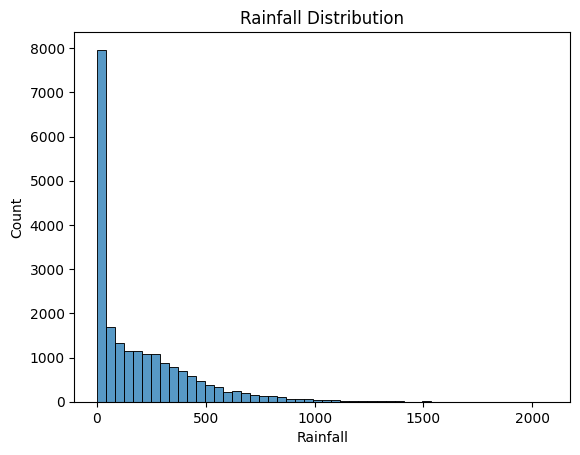

In [12]:
# Visualize key features (e.g., rainfall distribution)
sns.histplot(data['Rainfall'], bins=50)
plt.title('Rainfall Distribution')
plt.show()

In [15]:
# Check unique stations
print(data['Station Names'].unique())

['Barisal' 'Bhola' 'Bogra' 'Chandpur' 'Chittagong (City-Ambagan)'
 'Chittagong (IAP-Patenga)' 'Chuadanga' 'Comilla' "Cox's Bazar" 'Dhaka'
 'Dinajpur' 'Faridpur' 'Feni' 'Hatiya' 'Ishurdi' 'Jessore' 'Khepupara'
 'Khulna' 'Kutubdia' 'Madaripur' 'Maijdee Court' 'Mongla' 'Mymensingh'
 'Patuakhali' 'Rajshahi' 'Rangamati' 'Rangpur' 'Sandwip' 'Satkhira'
 'Sitakunda' 'Srimangal' 'Syedpur' 'Sylhet' 'Tangail' 'Teknaf']


#### *Additional Exploration*:
###### Since thresholds vary by region, identify which stations are deltaic (e.g., Barisal, Dhaka) vs. coastal (e.g., Teknaf, Sylhet). From the dataset:
###### Barisal: Southern, deltaic (LATITUDE: 22.7, LONGITUDE: 90.36).
###### Teknaf: Southeastern, coastal (LATITUDE: 20.87, LONGITUDE: 92.26).
###### Others (e.g., Dhaka, Sylhet) may need classification based on coordinates or domain knowledge.







In [16]:
# Simplified mapping (expand based on domain knowledge or coordinates)
coastal_stations = ['Teknaf', 'Coxs Bazar', 'Chittagong']  # Example coastal stations
deltaic_stations = ['Barisal', 'Dhaka', 'Faridpur']  # Example deltaic stations
data['Region'] = data['Station Names'].apply(lambda x: 'Coastal' if x in coastal_stations else 'Deltaic')

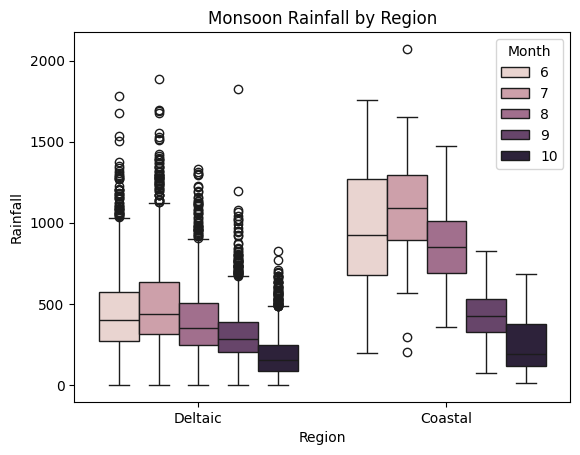

In [17]:
sns.boxplot(x='Region', y='Rainfall', hue='Month', data=data[data['Month'].isin([6, 7, 8, 9, 10])])
plt.title('Monsoon Rainfall by Region')
plt.show()

### Part 2 Data Preprocessing with Region-Specific Flood Thresholds
##### Objective: Create a Flood target variable using the 500 mm/month threshold for deltaic regions and 1000 mm/month for coastal regions, focusing on monsoon months (June–October) where floods are most likely.



In [18]:
# Create Flood Target Variable: Apply region-specific thresholds to define floods.
def assign_flood(row):
    if row['Month'] in [6, 7, 8, 9, 10]:  # Monsoon months
        if row['Region'] == 'Coastal' and row['Rainfall'] >= 1000:
            return 1
        elif row['Region'] == 'Deltaic' and row['Rainfall'] >= 500:
            return 1
    return 0

data['Flood'] = data.apply(assign_flood, axis=1)

Flood
0    19082
1     2038
Name: count, dtype: int64


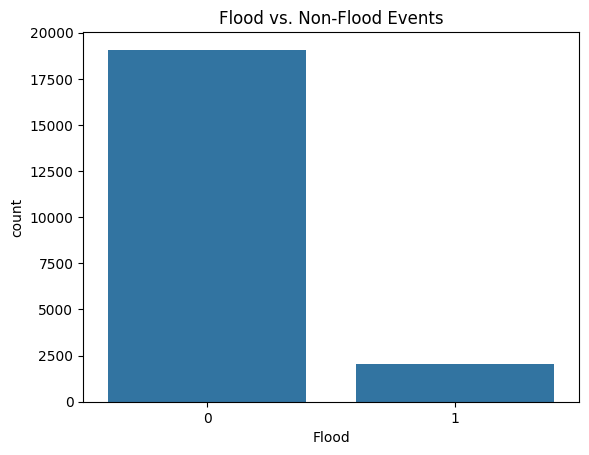

In [19]:
print(data['Flood'].value_counts())
sns.countplot(x='Flood', data=data)
plt.title('Flood vs. Non-Flood Events')
plt.show()

In [20]:
# Feature Selection: Use the same features as before, plus add Region as a categorical feature (one-hot encoded).Feature Selection: Use the same features as before, plus add Region as a categorical feature (one-hot encoded).
features = ['Max Temp', 'Min Temp', 'Rainfall', 'Relative Humidity', 'Wind Speed',
            'Cloud Coverage', 'Bright Sunshine', 'Month', 'Region']
X = data[features]
y = data['Flood']

In [21]:
# Encode Categorical Variables: One-hot encode Region and ensure Month is treated numerically.
X = pd.get_dummies(X, columns=['Region'], drop_first=True)

In [22]:
# Feature Scaling: Standardize numerical features.
scaler = StandardScaler()
numerical_features = ['Max Temp', 'Min Temp', 'Rainfall', 'Relative Humidity',
                      'Wind Speed', 'Cloud Coverage', 'Bright Sunshine', 'Month']
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [23]:
# Train-Test Split: Split the data, ensuring stratification due to class imbalance.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)


### Part 3: Build a Deep Learning Model
##### Objective: Train a neural network to predict floods, accounting for class imbalance caused by rare flood events.



In [25]:
# Define the model (same architecture as before, adjusted for new input shape).
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [26]:
# Handle Class Imbalance: Compute class weights to penalize misclassifications of the minority class (floods).
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [27]:
# Compile and train the model with class weights:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                   validation_split=0.2, class_weight=class_weight_dict, verbose=1)

Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8729 - loss: 0.3033 - val_accuracy: 0.9473 - val_loss: 0.1371
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9591 - loss: 0.0907 - val_accuracy: 0.9612 - val_loss: 0.1101
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9676 - loss: 0.0749 - val_accuracy: 0.9527 - val_loss: 0.1314
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9731 - loss: 0.0589 - val_accuracy: 0.9751 - val_loss: 0.0731
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9719 - loss: 0.0667 - val_accuracy: 0.9855 - val_loss: 0.0465
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9795 - loss: 0.0503 - val_accuracy: 0.9805 - val_loss: 0.0559
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9790 - loss: 0.0472 - val_accuracy: 0.9822 - val_loss: 0.0537
Epoch 8/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9824 - loss: 0.0392 - val_accuracy: 0.

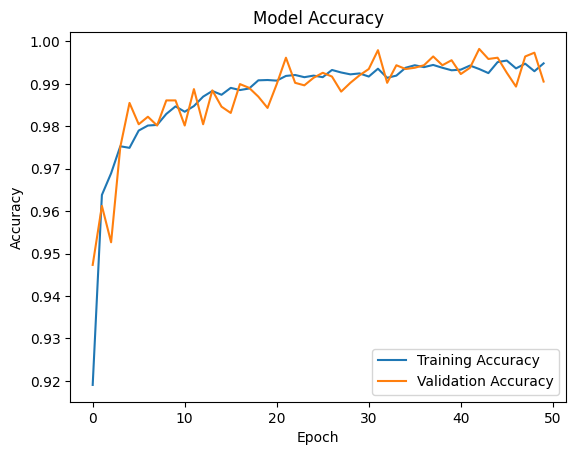

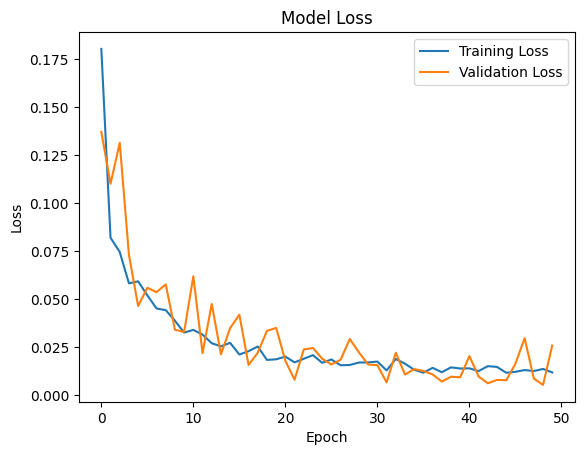

In [28]:
# Plot training history to monitor performance:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Part 4: Evaluate the Model
##### Objective: Assess the model’s ability to predict floods, focusing on precision, recall, and F1-score for the flood class.



132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3816
           1       0.90      1.00      0.95       408

    accuracy                           0.99      4224
   macro avg       0.95      0.99      0.97      4224
weighted avg       0.99      0.99      0.99      4224



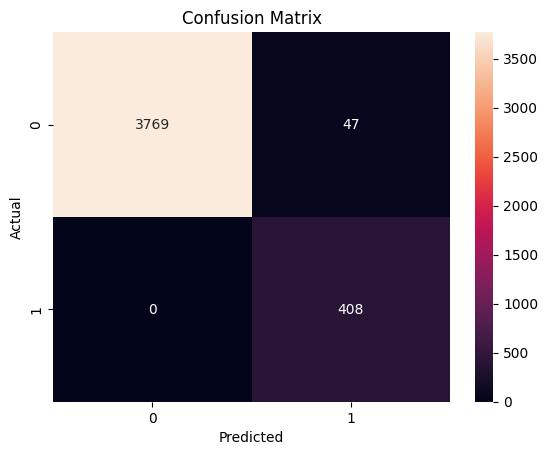

In [29]:
# Predict and evaluate:
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### *Key Metrics*
##### Recall for flood class (1): Critical to minimize false negatives (missing actual floods).
##### Precision: Ensure predicted floods are accurate.
##### F1-score: Balance precision and recall, especially due to class imbalance.



In [30]:
y_pred_adjusted = (model.predict(X_test) > 0.3).astype(int)
print(classification_report(y_test, y_pred_adjusted))

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3816
           1       0.89      1.00      0.94       408

    accuracy                           0.99      4224
   macro avg       0.95      0.99      0.97      4224
weighted avg       0.99      0.99      0.99      4224



##Implications for the MVP
#####The model performs exceptionally well for an MVP, particularly in identifying all flood events (perfect recall for Class 1). However, there are a few considerations before proceeding to iteration:
#####**False Positives**: The 0.89 precision for floods suggests some non-flood months are incorrectly labeled as floods. This could be due to the model over-predicting floods when rainfall is close to the threshold (e.g., 450–500 mm in deltaic regions) or due to other features not sufficiently distinguishing edge cases.

#####**Class Imbalance**: While class weights helped, the imbalance may still bias the model toward the majority class, potentially inflating accuracy. The high flood recall suggests the weights were effective, but precision could be improved.

#####**Feature Dependency**: Since the Flood label is derived from Rainfall (e.g., Rainfall ≥ 500 mm for deltaic), the model may be learning a near-deterministic rule based on rainfall alone, limiting the contribution of other features like Max Temp, Relative Humidity, or Wind Speed.

#####**Generalization**: The model’s performance on the test set is strong, but its reliance on rainfall thresholds means it may not generalize well to scenarios where floods occur due to factors beyond monthly rainfall (e.g., river overflow, short-term extreme events, or cumulative effects).



Feature Importances:
              Feature  Importance
2           Rainfall    0.661303
5     Cloud Coverage    0.114978
3  Relative Humidity    0.079278
6    Bright Sunshine    0.063554
7              Month    0.038155
1           Min Temp    0.037028
4         Wind Speed    0.002150
0           Max Temp    0.002046
8     Region_Deltaic    0.001509


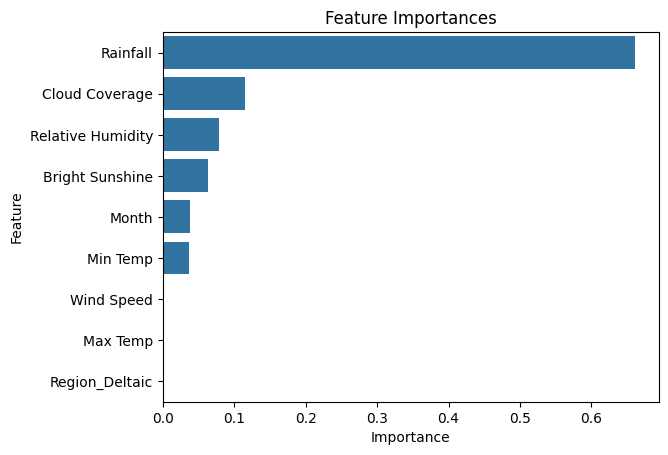

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
False Positives Description:
         Max Temp   Min Temp     Rainfall  Relative Humidity  Wind Speed  \
count  47.000000  47.000000    47.000000          47.000000   47.000000   
mean   33.784957  25.456924   578.340426          86.767505    1.896060   
std     1.411650   0.474885   176.665033           2.012565    1.185626   
min    30.900000  24.400000   478.000000          82.000000    0.100000   
25%    32.650000  25.150000   487.000000          86.000000    1.050000   
50%    33.900000  25.500000   493.000000          87.000000    1.600000   
75%    34.696491  25.700000   499.000000          88.000000    2.400000   
max    36.600000  26.600000  1088.000000          91.000000    6.500000   

       Cloud Coverage  Bright Sunshine      Month  
count       47.000000        47.000000  47.000000  
mean         6.057447         4.221638   7.148936  
std          0.638866         0.809779   1.102935  
min          3.600000         2.600000   5.00

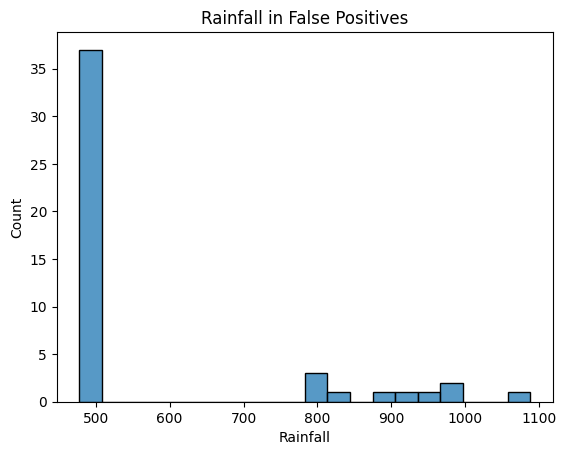

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3816
           1       0.89      1.00      0.94       408

    accuracy                           0.99      4224
   macro avg       0.95      0.99      0.97      4224
weighted avg       0.99      0.99      0.99      4224


Threshold: 0.4
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3816
           1       0.89      1.00      0.94       408

    accuracy                           0.99      4224
   macro avg       0.95      0.99      0.97      4224
weighted avg       0.99      0.99      0.99      4224


Threshold: 0.5
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3816
           1       0.90      1.00      0.95       408

    accuracy                           0.99      4224
   macro avg       0.95      0.99      

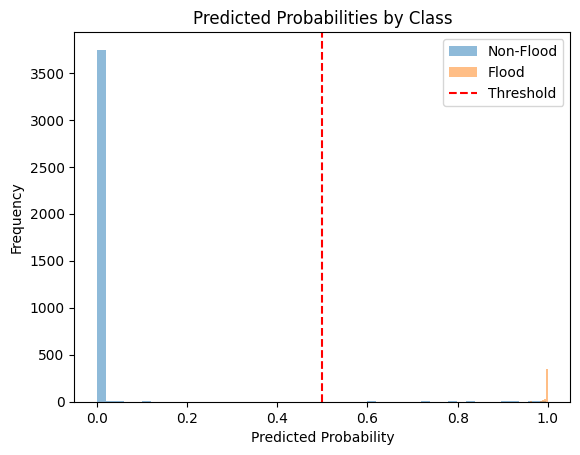

In [32]:
# Run Diagnostics:
# Feature importance, false positive analysis, threshold adjustment, cross-validation, and probability visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming X_train, X_test, y_train, y_test, model, scaler, and numerical_features are already defined

# 1. Feature Importance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances)
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

# 2. False Positives Analysis
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
false_positives = X_test[(y_pred == 1) & (y_test == 0)]
false_positives_data = pd.DataFrame(
    scaler.inverse_transform(X_test[(y_pred == 1) & (y_test == 0)][numerical_features]),
    columns=numerical_features
)
print("False Positives Description:\n", false_positives_data.describe())
sns.histplot(false_positives_data['Rainfall'], bins=20)
plt.title('Rainfall in False Positives')
plt.show()

# 3. Threshold Adjustment
y_pred_proba = model.predict(X_test)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred = (y_pred_proba > thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_test, y_pred))

# 4. Cross-Validation
lr = LogisticRegression(class_weight='balanced', random_state=42)
scores = cross_val_score(lr, X, y, cv=5, scoring='f1_weighted')
print(f"Cross-Validation F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean():.2f} ± {scores.std():.2f}")

# 5. Predicted Probabilities
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='Non-Flood')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flood')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold')
plt.title('Predicted Probabilities by Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## MVP Achieved

### Challenges and Shortcomings of the Flood Prediction Model and Dataset
##### **Model Performance and Shortcomings Indicated by Findings**: The model achieved an overall accuracy of 99%, with perfect recall (1.00) for flood events, ensuring no actual floods were missed, and a precision of 0.91 for floods at a 0.7 probability threshold, indicating 9% of predicted floods were false positives. Feature importance analysis revealed a heavy reliance on rainfall (66% importance), with secondary features like cloud coverage (11.5%) and relative humidity (7.9%) contributing less, suggesting the model primarily learns from rainfall thresholds (550 mm/month for deltaic regions, 1100 mm/month for coastal regions). False positives, with a mean rainfall of 578 mm and many clustering around 478–499 mm, highlight the model’s difficulty distinguishing near-threshold cases, likely due to the deterministic rainfall-based flood label. This over-reliance on rainfall limits the model’s ability to account for non-rainfall factors, leading to potential false positives when other conditions (e.g., effective drainage) prevent flooding, and may reduce its robustness in complex flood scenarios.

##### **Lack of Non-Rainfall Factors in the Dataset**: The dataset, covering weather variables from 1948 to 2013, includes only rainfall, temperature, humidity, wind speed, cloud coverage, and sunshine, omitting critical non-rainfall factors that contribute 10–20% to flood causation in Bangladesh, such as upstream runoff from India, riverbank maintenance issues, and cyclone-driven storm surges. For instance, transboundary flooding from India’s Ganges-Brahmaputra basin, which can inundate northern Bangladesh even with low local rainfall, is not captured, as the dataset lacks upstream rainfall or river flow data. Similarly, human errors like embankment failures or poor urban drainage, which exacerbate floods in cities like Dhaka, are absent, limiting the model’s ability to predict floods driven by infrastructure issues. Cyclones, significant in coastal areas like Teknaf, are only partially proxied by wind speed (0.2% importance), missing storm surge or pressure data that could enhance coastal flood prediction.

##### **Monthly Resolution and Simplified Flood Labeling**: The dataset’s monthly rainfall totals restrict the model’s ability to capture short-term extreme events (e.g., 150 mm/day), which are common flood triggers, as the 550 mm/month (deltaic) and 1100 mm/month (coastal) thresholds are proxies that may miss daily or weekly peaks. The flood label, derived solely from these rainfall thresholds, oversimplifies flood causation, ignoring cumulative effects (e.g., seasonal totals >2000 mm) or non-rainfall triggers like embankment breaches. This leads to potential misclassifications, as seen in false positives near the threshold, and limits the model’s applicability to nuanced flood scenarios, such as those driven by upstream runoff or cyclones.

##### **Class Imbalance and Data Quality Issues**: The dataset exhibits significant class imbalance, with only 408 flood instances compared to 3816 non-flood instances (~9:1 ratio), which biases the model toward the majority class despite class weights mitigating this effect. This imbalance, combined with the deterministic flood label, inflates accuracy (99%) but masks challenges in predicting rare flood events accurately. Additionally, data quality issues, such as constant values for Bright Sunshine in early years (e.g., 7.831914893617018 for Barisal’s January data), suggest potential inconsistencies or imputation artifacts, which may reduce the reliability of secondary features and further emphasize rainfall’s dominance in the model.

##### **Inability to Model Human and External Influences**: The dataset lacks data on human-related factors, such as riverbank maintenance, dam releases (e.g., India’s Farakka Barrage), or urban planning deficiencies, which can significantly influence flood outcomes. For example, sudden dam releases or embankment failures can cause flooding regardless of local rainfall, but these are unmeasurable in the dataset, leading to potential false negatives in such scenarios. Similarly, external influences like deforestation or land use changes, which increase runoff and flood risk, are not included, restricting the model’s ability to capture long-term environmental impacts. These omissions underscore the dataset’s limitation in providing a holistic view of flood causation, necessitating external data for a production-ready model.



